## Loading datasets and shuffling

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
# import cv2
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV, KFold
from sklearn.utils import shuffle

train_df = pd.read_csv("/kaggle/input/emnist/emnist-letters-train.csv")
test_df = pd.read_csv("/kaggle/input/emnist/emnist-letters-test.csv")

train_df.columns = [i for i in range(785)]
test_df.columns = [i for i in range(785)]

print(train_df.shape)
print(train_df.info())
print(test_df.shape)
print(test_df.info())
dataset = pd.concat([train_df, test_df], axis=0)
print(dataset.shape)
print(dataset.info())
dataset = pd.DataFrame(shuffle(dataset))
print(dataset.shape)


(88799, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88799 entries, 0 to 88798
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 531.8 MB
None
(14799, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14799 entries, 0 to 14798
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 88.6 MB
None
(103598, 785)
<class 'pandas.core.frame.DataFrame'>
Index: 103598 entries, 0 to 14798
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 621.2 MB
None
(103598, 785)


## Splitting the dataset into features and labels

In [38]:
labels = dataset.iloc[:, 0]
print(labels.shape)

features = dataset.iloc[:, 1:]
print(features.shape)

(103598,)
(103598, 784)


## Building label map

In [39]:
mp = dict()
for i in range(0, 26):
    mp[i+1] = chr(ord('a') + i)
print(mp)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


## Preprocessing images so all have same orientation and shuffling

In [40]:
features = np.array(features)
print(features.shape)
features = features / 255.0

features_image = features.reshape(-1, 28, 28, 1) # adjust on the number of rows, each image is grey 28 * 28
features_image = np.rot90(features_image, axes=(1, 2))
features_image = np.flip(features_image, axis=1)


(103598, 784)


## Drawing images function

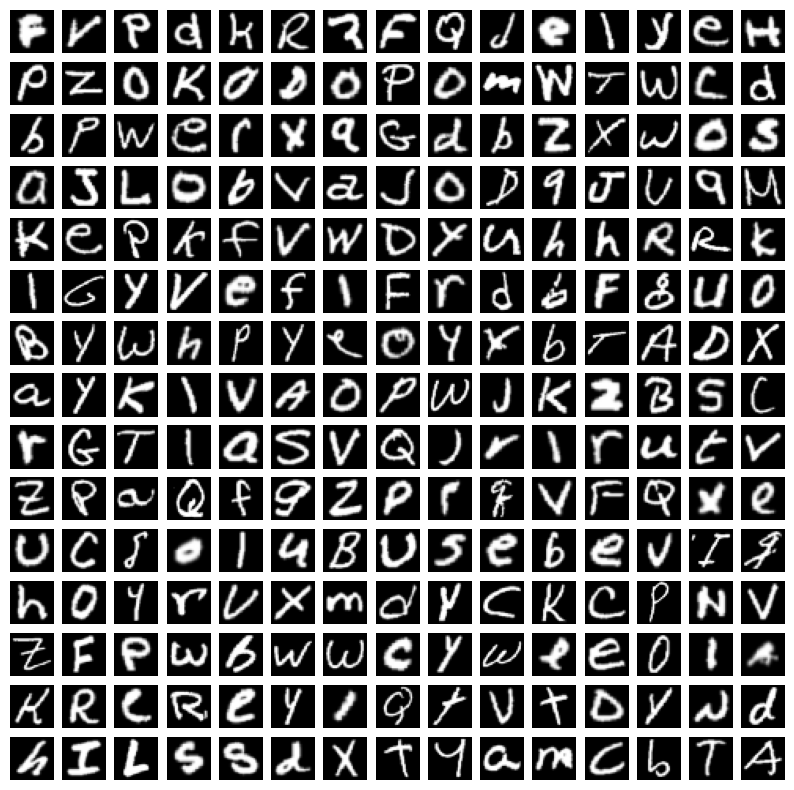

In [41]:
def draw_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j], cmap="gray")
            axs[i,j].axis('off')
    plt.show()

indices = np.random.choice(features_image.shape[0], 300) # choose from 0 to 103598 (shape[0]) 300 element
draw_images(features_image[indices].squeeze(), 15, 15)

## train_test_split And fitting model using params from merged

In [42]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.8,
                                                     test_size=0.2, stratify=labels, random_state=42)

param_grid = {'n_estimators': [200]}

kf = KFold(n_splits=3, shuffle=True, random_state=42)


# Getting params from optimal grid_search in unmerged_DT
classifier = RandomForestClassifier(ccp_alpha= 0.0, class_weight= None, criterion='entropy',
            max_depth=20, max_features= None, max_leaf_nodes= None,
            min_impurity_decrease= 0.0, min_samples_leaf= 4, min_samples_split= 10,
              min_weight_fraction_leaf= 0.0, random_state= 42, n_jobs=-1)

grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=kf, scoring='accuracy')


grid_search.fit(X_train, y_train)

classifier = grid_search.best_estimator_
joblib.dump(classifier, 'best_RF_model_200_merged.joblib')

print("Best cross-validated accuracy:", grid_search.best_score_)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusionMatrix = confusion_matrix(y_test, y_pred)
print("classifier.score(X_test, y_test): ", classifier.score(X_test, y_test))
print(f'Accuracy of the Best Model: {accuracy}')
print("Classification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusionMatrix)



Best cross-validated accuracy: 0.8220034267236178
classifier.score(X_test, y_test):  0.8326737451737452
Accuracy of the Best Model: 0.8326737451737452
Classification Report: 
               precision    recall  f1-score   support

           1       0.74      0.82      0.78       839
           2       0.82      0.85      0.83       839
           3       0.86      0.89      0.87       844
           4       0.85      0.81      0.83       840
           5       0.87      0.87      0.87       848
           6       0.87      0.82      0.85       839
           7       0.78      0.64      0.70       837
           8       0.83      0.84      0.84       845
           9       0.70      0.72      0.71       846
          10       0.87      0.85      0.86       840
          11       0.84      0.85      0.85       848
          12       0.67      0.71      0.69       843
          13       0.92      0.90      0.91       840
          14       0.84      0.87      0.86       833
          15 

## Drawing ROC Curve

(20720, 26) (20720, 26) [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (20720,)


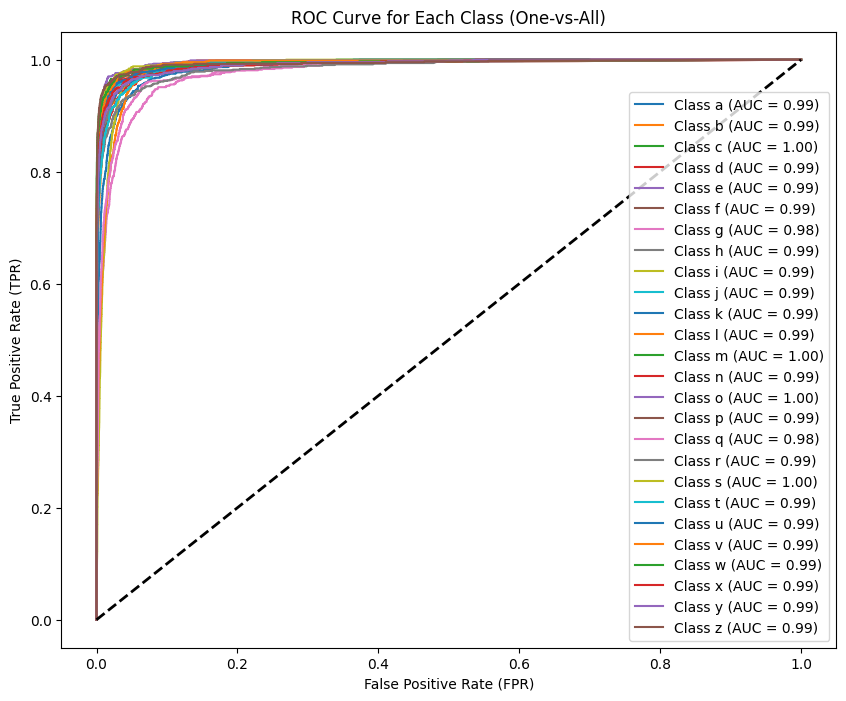

In [43]:
from sklearn.preprocessing import LabelBinarizer
y_score = classifier.predict_proba(X_test)
# print("Train labels: ")
# print(pd.DataFrame(y_train).value_counts())
# print("----------------------------------------------------------------------------")
# print(pd.DataFrame(y_score).value_counts())
# print("y_score_proba: shape ", y_score.shape)
# print("----------------------------------------------------------------------------")
# print("Pred labels: ")
# print(pd.DataFrame(y_pred).value_counts())
# print("----------------------------------------------------------------------------")
# print("test_labels: ")
# print(pd.DataFrame(y_test).value_counts())
# print("----------------------------------------------------------------------------")
# print("train_labels: ")
# print(pd.DataFrame(y_train).value_counts())
# print("----------------------------------------------------------------------------")
# print("train_labels: ")
# print(np.array(y_train.shape))

label_binarizer = LabelBinarizer()
y_bin = label_binarizer.fit_transform(y_test)

print(y_score.shape, y_bin.shape, y_bin[0], y_test.shape)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 26
for i in range(1, n_classes + 1):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i-1], y_score[:, i-1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(1, n_classes + 1):
    plt.plot(fpr[i], tpr[i], label=f'Class {mp[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Each Class (One-vs-All)')
plt.legend(loc='lower right')
plt.show()

## Confusion Matrix

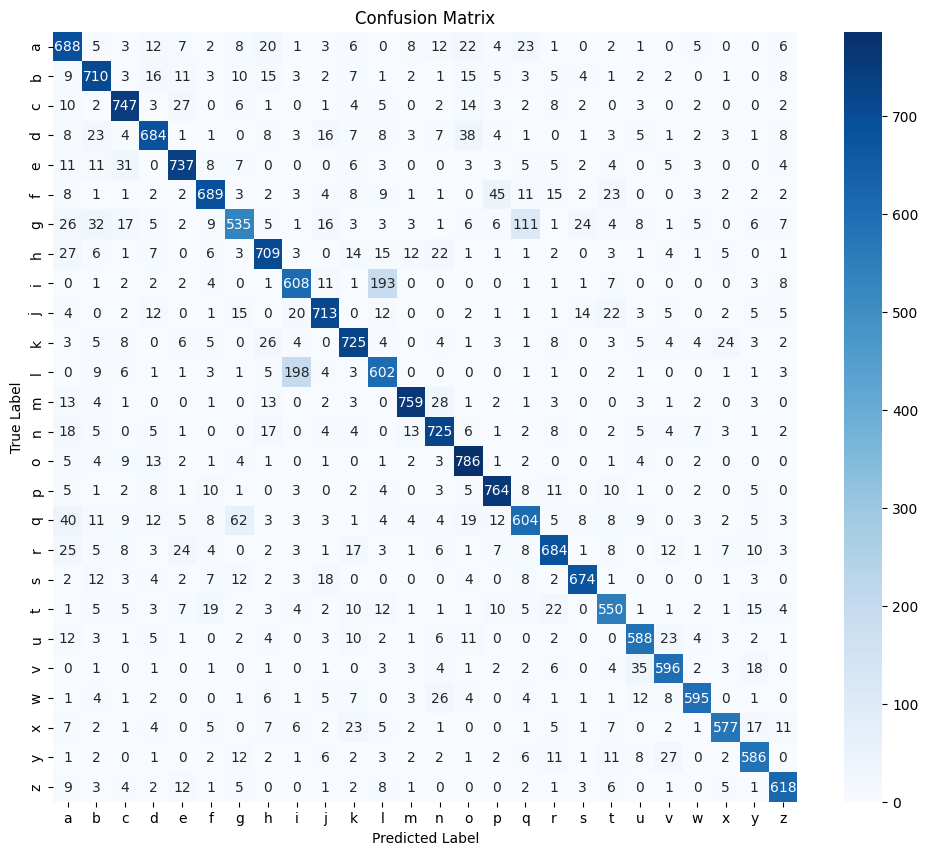

In [44]:
import seaborn as sns

ls = []
for i in range(n_classes):
    ls.append(mp[i+1])

plt.figure(figsize=(12, 10))

sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=ls, yticklabels=ls)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Predicting Output

(103598, 784)
i
(28, 28, 1)


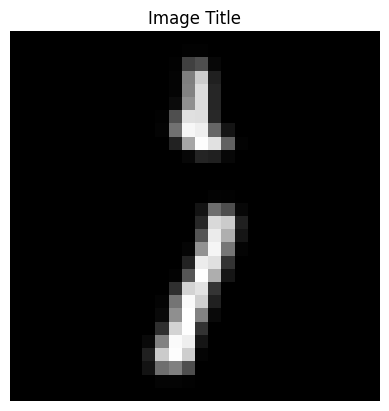

i
True


In [45]:
myRow = dataset.iloc[8, :] # enter row number
label = myRow.iloc[0]
features_pred = myRow[1:]
features_pred = np.array(features_pred)
print(features.shape)
features_image = features_pred.reshape((1,28,28,1))
features_image = np.rot90(features_image, axes=(1, 2))
features_image = np.flip(features_image, axis=1)
features_image = features_image.reshape((28,28,1))

print(mp[label])
print(features_image.shape)
plt.imshow(features_image, cmap='gray')
plt.title('Image Title')
plt.axis('off')  # Optional: Turn off axis labels
plt.show()
classifier = joblib.load('/kaggle/working/best_RF_model_merged.joblib')
y_pred = classifier.predict(features_pred.reshape(1, -1))
print(mp[y_pred[0]])
print(y_pred[0] == label)